In [1]:
# to run without requiring jupyter notebook, see the main.py file

## Load modules
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import os
import dataHelp as dh
import paramSearchHelper as psh
cwd = os.getcwd() # current working directory
import sys
sys.path.append(os.path.abspath(cwd))
import utils
import NNModel as NN

In [2]:
# set "param_file" to the name of a .json file in the settings folder 
param_file = "nn_incline-load_conditions_subj"

In [3]:
# load the params file
param_dir = cwd+"/"+"settings" # change directory to settings
if (param_file == "-f"):
    print("No input .json file given")
else:
    param_path = param_dir+"/"+param_file+".json"
    params = utils.Params(param_path) # load setting file

# convert params strings bools to booleans
def str2bool(v):
  return v.lower() in ("true")

# Model type
model_type = params.model_type
sim_type = params.sim_type # hps:hyperparam search, sm:single model train, subj: test set of 10 subjects
batch_size = params.batch_size #128 # 1 to not batch
sequence_length = params.sequence_length # this should be however many "bins" we use
num_epochs = params.num_epochs # total number of epochs to iterate through

# Load data
data_folder = params.data_folder
data_type = params.data_type # subjects, conditions, or data
features = params.features
signals = params.signals
y_ind = params.y_ind # which metabolic predictor to use
norm = str2bool(params.norm) # whether to normalize data
seed = params.seed
if data_folder[:8] == "assisted": # assisted dataset
    seed_list = [2,10,3,5,25,1,9,7] # first random seed numbers to get the subjects in order
else: # incline-load dataset
    seed_list = [41,17,13,5,7,1,40,32,2,10,3,12,9]

train_size = params.train_size

if (data_type == "subjects") and (sim_type == "hps" or sim_type == "sm"):
    if data_folder[:8] == "assisted":
        test_size = 2
    else:
        test_size = 3
elif (data_type == "subjects" or data_type[0:8] == "subjcond"):
    test_size = 1
else:
    test_size = 0.1

if params.test_size != -1: # not using default
    test_size = params.test_size

# Single model settings
learning_rate = params.learning_rate
print_interval = params.print_interval # number of prints
plot_interval = params.plot_interval # data points in the plots
num_hid_layers = params.num_hid_layers
size_hid_layers = params.size_hid_layers
printing = str2bool(params.printing) # True prints the losses and train/test errors as the network is trained
plotting = str2bool(params.plotting)
num_sims = params.num_sims # number of simulations run for the hyperparamSearch
beta = params.beta
k_p = params.k_p
reg_type = params.reg_type
saving = str2bool(params.saving)
log_dir = data_type+"_"+ data_folder
parallel = str2bool(params.parallel)
cores = params.cores # number of cores to run parallel trials
decay = str2bool(params.decay)
batch_norm = str2bool(params.batch_norm)

lr_rng = [params.lr_min, params.lr_max]
num_hid_layers_rng = [params.num_hl_min, params.num_hl_max]
size_hid_layers_rng = [params.sz_hl_min, params.sz_hl_max]
beta_rng = [params.beta_min, params.beta_max]
k_p_rng = [params.k_p_min, params.k_p_max]

Test conditions:  [28, 122, 92, 88, 105, 86, 84, 131, 109, 26, 151, 89, 65, 80, 140]
Test conditions:  [131, 10, 41, 17, 129, 7, 39, 68, 31, 22, 57, 150, 134, 143, 111]
Test conditions:  [11, 24, 1, 148, 139, 2, 52, 75, 73, 154, 126, 98, 16, 74, 82]
Test conditions:  [86, 30, 65, 44, 27, 80, 113, 143, 7, 112, 8, 73, 144, 118, 99]
Test conditions:  [135, 127, 68, 136, 42, 110, 89, 72, 23, 142, 92, 103, 151, 67, 25]
Test conditions:  [50, 139, 101, 20, 25, 134, 71, 129, 144, 79, 133, 137, 72, 140, 37]
Test conditions:  [14, 8, 145, 49, 73, 91, 55, 74, 19, 114, 71, 12, 50, 7, 70]
Test conditions:  [35, 65, 150, 139, 4, 9, 3, 89, 71, 147, 88, 124, 54, 133, 43]
Test conditions:  [37, 116, 124, 31, 63, 47, 151, 95, 7, 104, 75, 43, 22, 72, 15]
Test conditions:  [139, 100, 16, 115, 40, 0, 73, 8, 151, 123, 113, 64, 15, 125, 9]
Test conditions:  [2, 66, 81, 26, 142, 93, 119, 138, 107, 147, 21, 0, 131, 152, 106]
Test conditions:  [13, 104, 117, 128, 74, 118, 141, 133, 49, 22, 76, 3, 130, 134, 75]

START OF NEW SUBJECT RUN
Avg Train Error: 0.029130
Avg Test Error: 0.060882
Std Test Error: 0.008547
Subject Test Errors: [0.04646702245192176, 0.05592734778808624, 0.053031983397897026, 0.06088239578830389, 0.06735097601834508, 0.059987639578131524, 0.05531279934417519, 0.07974870668335772, 0.054932737687378, 0.057709788279458565, 0.07085950869364277, 0.06977985309428945, 0.059476683195636974]
Avg Train R^2: 0.986807
Avg Test RMSE: 38.708237
Avg Test MAE: 29.800008
PREDICTED THEN ACTUAL RESULTS BELOW
[[571.4398, 457.44165, 543.7947, 654.62756, 375.51227, 642.2462, 535.35284, 756.00085, 793.9379, 302.30737, 297.96722, 611.8475, 823.5933, 662.2996, 548.41626], [425.2396, 425.38962, 401.3453, 304.58575, 504.60464, 386.13538, 621.2002, 446.06488, 595.09094, 248.09364, 437.84348, 827.7981, 591.32385, 740.95074, 411.5614], [368.57343, 455.5405, 590.74615, 297.26172, 302.96585, 518.1688, 456.52097, 558.57056, 377.58804, 581.46783, 422.89285, 456.66983, 517.3328, 455.7712, 559.0904], [417.169

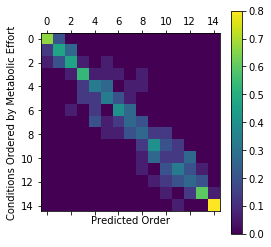

In [4]:
# Loading data and running the models/search/subjects
num_runs = len(seed_list) if sim_type == "subj" else 1
test_results = []
label_results = []
train_errs = []
train_r2 = []
train_rmse = []
train_mae = []
test_errs = []
test_rmse = []
test_mae = []

for i in range(num_runs): # loop through subjects if necessary
    if sim_type == "subj":
        seed = seed_list[i]
        printing = False
        plotting = False
        saving = False
        #data_type = "subjects"
        
    # Load data
    x_train, Y_train, x_dev, Y_dev, x_test, Y_test = dh.loadData(data_type, cwd, seed, y_ind, train_size, test_size, features, norm, data_folder, sequence_length, signals)

    if batch_size != 1: # need axis swap and/or batching
        X_train = x_train
        X_dev = x_dev
        X_test = x_test
        X_train, Y_train = dh.batch_nonseq(X_train, Y_train, batch_size)
    else:
        X_train = x_train
        X_dev = x_dev
        X_test = x_test
    if (sim_type == "sm") or (sim_type == "subj"):
        if model_type == "NN":
            results = NN.model(cwd, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, learning_rate, beta, k_p, reg_type, num_epochs, num_hid_layers, size_hid_layers, batch_size, log_dir, decay, batch_norm, saving, printing, plotting, print_interval, plot_interval, parallel, queue=0)
    elif sim_type == "hps":
        results = psh.hyperparamSearch(param_file, model_type, cwd, X_train, Y_train, X_dev, Y_dev, X_test, Y_test, lr_rng, num_hid_layers_rng, beta_rng, k_p_rng, reg_type, size_hid_layers_rng, num_sims, num_epochs, batch_size, log_dir, decay, batch_size, batch_norm, parallel, cores)

    if (sim_type == "subj"):
        # new output from NN model: results = train_err, train_r2, train_rmse, train_mae, dev_err, test_err, test_rmse, test_mae, min_dev, min_test, min_epoch, test_avg, Y_avg
        test_results.append(results[-2])
        label_results.append(results[-1])
        train_errs.append(results[0])
        train_r2.append(results[1])
        train_rmse.append(results[2])
        train_mae.append(results[3])
        test_errs.append(results[5])
        test_rmse.append(results[6])
        test_mae.append(results[7])
        
if (sim_type == "subj"):
    log_name = "Subj_run_"+str(model_type)+""+str(learning_rate)+""+str(num_epochs)+""+str(num_hid_layers)+""+str(size_hid_layers)
    try: # if no log folder exists, create it
        os.mkdir(cwd+"/"+log_dir)
    except:
        print("directory exists")
    utils.set_logger(os.path.join(cwd+"/"+log_dir,log_name+'.log'))
    utils.logging.info("START OF NEW SUBJECT RUN")
    utils.logging.info("Avg Train Error: %f", np.mean(train_errs))
    utils.logging.info("Avg Test Error: %f", np.mean(test_errs))
    utils.logging.info("Std Test Error: %f", np.std(test_errs))
    utils.logging.info("Subject Test Errors: "+str(test_errs))
    utils.logging.info("Avg Train R^2: %f", np.mean(train_r2))
    utils.logging.info("Avg Test RMSE: %f", np.mean(test_rmse))
    utils.logging.info("Avg Test MAE: %f", np.mean(test_mae))
    utils.logging.info("PREDICTED THEN ACTUAL RESULTS BELOW")
    utils.logging.info(test_results)
    utils.logging.info(label_results)

    dh.confusionMat(test_results, label_results, True, cwd+"/"+log_dir, log_name)